# Stock Price Direction Prediction using LSTM

In [77]:
import os
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Set Parameters and paths

In [69]:
csv_file_path = "/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv"
LOOKBACK = 3
EPOCHS = 10
BATCH_SIZE = 32

## Loading Data

In [34]:
# Load the dataset
dataset  = pd.read_csv(csv_file_path)
print(f"Dataset Length: {len(dataset)}")
dataset .head()

Dataset Length: 1825


,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [35]:
# Specify the columns to use as features
feature_columns = ['Close', 'Open', 'High', 'Low', 'Volume']

## Preprocessing data

In [36]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset[feature_columns])
scaled_data.shape

(1825, 5)

## Creating Input Sequences and Labels

In [40]:
def create_input_sequences(dataset, lookback):
    X = []
    y = []

    for i in range(lookback, len(dataset)):
        X.append(dataset[i - lookback:i, :])
        current_price = dataset[i, 0]
        previous_price = dataset[i - 1, 0]
        if current_price > previous_price:
            y.append(1)  # Stock price went up
        elif current_price < previous_price:
            y.append(-1)  # Stock price went down
        else:
            y.append(0)  # Stock price remained neutral

    return np.array(X), np.array(y)

Let's go through the first two iterations of the loop using the updated lookback value of 3 and explain the input sequences in detail.

**Iteration 1:**

* `i = 3`

* `X.append(scaled_data[i - lookback:i, :])` will append `scaled_data[0:3, :]` to `X`.

* The input sequence `X[0]` will contain the feature values of the first 3 time steps (t-1, t-2, t-3) for all 5 feature columns.
* Each row in the input sequence represents a time step, and each column represents a feature.
* So, `X[0]` will have the shape `(3, 5)` and will include the feature values of the following time steps:
    * Row 0: Feature values at time step t-1 (2nd time step)
    * Row 1: Feature values at time step t-2 (1st time step)
    * Row 2: Feature values at time step t-3 (0th time step)

**Iteration 2:**

* `i = 4`

* `X.append(scaled_data[i - lookback:i, :])` will append `scaled_data[1:4, :]` to `X`.

* The input sequence `X[1]` will contain the feature values of the 2nd, 3rd, and 4th time steps (t-1, t-2, t-3).

* `X[1]` will have the shape (3, 5) and will include the feature values of the following time steps:
    * Row 0: Feature values at time step t-1 (3rd time step)
    * Row 1: Feature values at time step t-2 (2nd time step)
    * Row 2: Feature values at time step t-3 (1st time step)

#### Explanation of Input Sequences
After running the loop from `lookback` to `len(dataset)`, the `X` list will contain input sequences for each iteration. The dimensions of `X` will be `(len(dataset) - lookback, lookback, len(feature_columns))`.

In this case:

The length of the dataset is 1825.
The lookback value is 3.
The number of feature columns is 5.
Therefore, the final dimensions of `X` will be `(1825 - 3, 3, 5)`, which simplifies to `(1822, 3, 5)`. This means that `X` will have 1822 input sequences, each with a length of 3 time steps, and each time step containing the feature values of all 5 feature columns.

#### Explanation of Input Labels
```python
if current_price > previous_price:
    y.append(1)  # Stock price went up
elif current_price < previous_price:
    y.append(-1)  # Stock price went down
else:
    y.append(0)  # Stock price remained neutral
```
    
Since we iterate from `lookback` to `len(dataset)`, the length of `y` will be `len(dataset) - lookback`.

Therefore, the length of `y` will be **1825 - 3**, which simplifies to **1822**.

Hence, the dimension of `y` will be `(1822,)`, indicating a one-dimensional array with 997 elements.

Each element in y represents the label for the corresponding input sequence in X, indicating the direction of the stock price movement for that specific time step:

* 1 represents an upward movement.
* -1 represents a downward movement.
* 0 represents a neutral movement.

In [64]:
X, y = create_input_sequences(scaled_data, LOOKBACK)
print(f"Shape of X: {X.shape}\nShape of y:{y.shape}")

Shape of X: (1822, 3, 5)
Shape of y:(1822,)


In [65]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
print(f"Shape of X_train: {X_train.shape}\nShape of y_train:{y_train.shape}\n")
print(f"Shape of X_test: {X_test.shape}\nShape of y_test:{y_test.shape}\n")

# Reshape the input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print("After reshaping ...\n")
print(f"Shape of X_train: {X_train.shape}\nShape of y_train:{y_train.shape}\n")
print(f"Shape of X_test: {X_test.shape}\nShape of y_test:{y_test.shape}")

Shape of X_train: (1275, 3, 5)
Shape of y_train:(1275,)

Shape of X_test: (547, 3, 5)
Shape of y_test:(547,)

After reshaping ...

Shape of X_train: (1275, 3, 5)
Shape of y_train:(1275,)

Shape of X_test: (547, 3, 5)
Shape of y_test:(547,)


In [66]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
# Train the model
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
40/40 [==============================] - 5s 9ms/step - loss: 0.4741 - accuracy: 0.3129
Epoch 2/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2431 - accuracy: 0.3129
Epoch 3/10
40/40 [==============================] - 0s 9ms/step - loss: 0.2418 - accuracy: 0.3129
Epoch 4/10
40/40 [==============================] - 0s 7ms/step - loss: 0.2379 - accuracy: 0.3129
Epoch 5/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2400 - accuracy: 0.3129
Epoch 6/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2447 - accuracy: 0.3129
Epoch 7/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2382 - accuracy: 0.3129
Epoch 8/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2361 - accuracy: 0.3129
Epoch 9/10
40/40 [==============================] - 0s 9ms/step - loss: 0.2364 - accuracy: 0.3129
Epoch 10/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2316 - accuracy: 0.3129


In [71]:
# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test) # Here, perhaps validation dataset can be used
print('Accuracy:', accuracy)

18/18 [==============================] - 1s 4ms/step - loss: 0.4028 - accuracy: 0.3071
Accuracy: 0.30712980031967163


In [96]:
# gt_labels = []
# for pred in y_test:
#     if pred == 1:
#         gt_labels.append('up')  # Stock price predicted to go up
#     elif pred == -1:
#         gt_labels.append('down')  # Stock price predicted to go down
#     elif pred == 0:
#         gt_labels.append('neutral')  # Stock price predicted to remain neutral

# print(gt_labels[:15])

['up', 'neutral', 'neutral', 'neutral', 'down', 'down', 'up', 'down', 'neutral', 'neutral', 'down', 'up', 'up', 'up', 'up']


18/18 [==============================] - 0s 4ms/step
Accuracy: 0.0
Classification Report:
              precision    recall  f1-score   support

          up       0.00      0.00      0.00       0.0
        down       0.00      0.00      0.00       0.0
     neutral       0.00      0.00      0.00       0.0

   micro avg       0.00      0.00      0.00       0.0
   macro avg       0.00      0.00      0.00       0.0
weighted avg       0.00      0.00      0.00       0.0

[[  0   0   0 158]
 [  0   0   0 168]
 [  0   0   0 221]
 [  0   0   0   0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Undefin

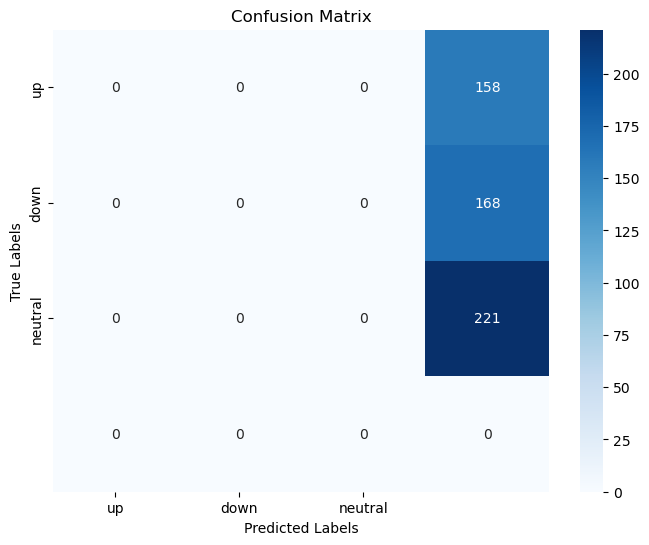

In [98]:
predictions = model.predict(X_test)

# print(predictions[:15])

# Define label names
label_names = ['up', 'down', 'neutral']

# Convert predictions to labels
predicted_labels = []
for pred in predictions:
    if pred > 0.5:
        predicted_labels.append('up')  # Stock price predicted to go up
    elif pred < -0.5:
        predicted_labels.append('down')  # Stock price predicted to go down
    else:
        predicted_labels.append('neutral')  # Stock price predicted to remain neutral

# print(predicted_labels)        
# Convert y_test to strings
y_test_str = [str(label) for label in y_test]

# Calculate accuracy
accuracy = accuracy_score(y_test_str, predicted_labels)

# Print the accuracy
print('Accuracy:', accuracy)

# Calculate and print the classification report
print('Classification Report:')
print(classification_report(y_test_str, predicted_labels, labels=label_names))

# Calculate and display the confusion matrix
confusion_mat = confusion_matrix(y_test_str, predicted_labels)

print(confusion_mat)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()